In [3]:
library(Seurat)
library(Signac)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v86)
library(ggplot2)
library(patchwork)
library(hdf5r) 
library(future)
library(RColorBrewer)
library(dplyr)
library(Matrix)
library(BSgenome.Hsapiens.UCSC.hg38)
library(glue)
library(harmony)
library(matrixStats)
library(scales)
library(biomaRt)
library(curl)
library(goseq)
library(httr)
library(Scillus)
library(TFBSTools)
library(JASPAR2020)
library(ggridges)
library(ggrepel)
library(ggsignif)
library(qusage)
library(tidyverse)
httr::set_config(config(ssl_verifypeer = 0L))
set.seed(1234)
setwd('data/inhouse_wu_long_yu')

In [2]:
source('../../snatac-rcc-manuscript-data/functions.r')

# Figure 3A: ccRCC C3 peak signature score and BAP1 mutation status

Differential peak accessibility results can be found in Supp table 2, sheet B. 

In [4]:
# Read in ccrcc DAPs and filter to those significant in c3 vs all other clusters analysis
da_peaks = read.table("allcells/tumor/findmarkers/ccrcc_balanced_peaks_nov2023.txt", row.names = NULL)
sigpeaks = da_peaks %>% filter(p_val_adj < 0.05)
c3_peaks = (sigpeaks %>% filter(cluster == 3))$gene

Calculate C3 peak signature score on ccRCC tumor cells

In [5]:
ccrcc = readRDS('allcells/tumor/seurat_obj/integrated_ccrcc_c0123_plof_anno_Oct2023.rds')
c3_sigs = calculate_signature_scores(seurat_object = ccrcc, sig_peak_set = c3_peaks, pct.open = 0.1, final_score_name = 'cluster3_signature')
ccrcc = AddMetaData(ccrcc, metadata = c3_sigs)

Matching GC.percent distribution



Prep data and calculate q-value

In [6]:
# Filter to BAP1 LOF or WT cells only
metadata <- ccrcc@meta.data %>%
  dplyr::filter(BAP1_LOF == 1 | BAP1 == 0) %>%
  dplyr::mutate(
    BAP1 = ifelse(BAP1 == 1, "pLOF", "WT"),
    BAP1 = factor(BAP1, levels = c("pLOF", "WT"))
  )

# Calculate q-value of comparison to show in plot
df <- metadata %>%
  dplyr::group_by(biopsy, BAP1) %>%
  dplyr::summarise(median_sig = median(cluster3_signature), .groups = "drop")

## Extract median signature scores for WT and pLOF groups
wt <- df %>% dplyr::filter(BAP1 == "WT") %>% dplyr::pull(median_sig)
mt <- df %>% dplyr::filter(BAP1 == "pLOF") %>% dplyr::pull(median_sig)

## Perform Wilcoxon test and adjust p-value
qval <- p.adjust(wilcox.test(mt, wt)$p.value, n = 3)

## Define y-axis position for annotation
y_scale_range <- max(c(wt, mt)) - min(c(wt, mt))
ypos <- max(c(wt, mt)) + y_scale_range * 0.05


Plot, add q-value

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
"Computation failed in `stat_signif()`
Caused by error in `if (scales$x$map(comp[1]) == data$group[1] | manual) ...`:
! missing value where TRUE/FALSE needed"


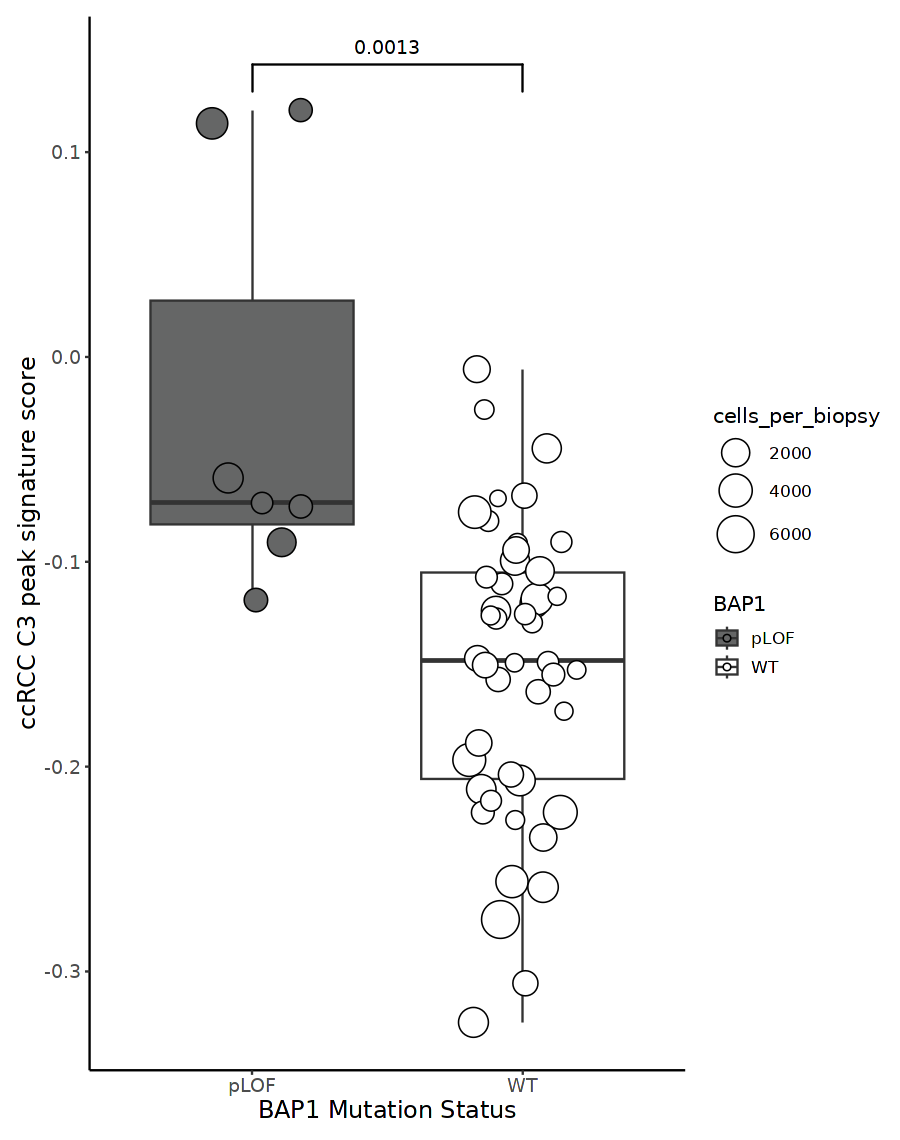

In [7]:
# Plot
options(repr.plot.width = 7.5, repr.plot.height = 9.5)
plot_signature_by_mutation(
  data = metadata,
  mutation_column = "BAP1",
  signature = "cluster3_signature"
) +
  scale_size(range = c(4, 10)) +
  scale_fill_manual(values = c("#656666", "white")) +
  ylab("ccRCC C3 peak signature score") +
  geom_signif(
    xmin = "pLOF",
    xmax = "WT",
    y_position = ypos,
    annotation = formatC(qval, digits = 2)
  )


# Figure 3B: BAP1 mutation status tumor peak heatmap

## Increased accessibility with pLOF BAP1 mutation

Differential peak accessibility results in Supp Table 3, sheet A. 

Calculate differential accessibility and filter results. 

In [7]:
DefaultAssay(ccrcc) = 'ATAC'
groupa = (ccrcc@meta.data %>% filter(BAP1_LOF == 1, stage %in% c(3,4)))$new_barcodes
groupb = (ccrcc@meta.data %>% filter(BAP1 == 0, stage %in% c(3,4)))$new_barcodes
markers = FindMarkers(ccrcc, `ident.1` = groupa, `ident.2` = groupb, min.pct = 0.1, test.use = 'LR', latent.vars = 'nCount_ATAC', logfc.threshold = 0.1)
markers$gene = row.names(markers)
filtered_markers = markers %>% filter((p_val_adj < 0.05) & (avg_log2FC >1))

Create an average accessibility object
1. Subset object to late stage, BAP1 pLOF or WT

In [10]:
groupa = (ccrcc@meta.data %>% filter(BAP1_LOF == 1, stage %in% c(3,4)))$new_barcodes
groupb = (ccrcc@meta.data %>% filter(BAP1 == 0,stage %in% c(3,4)))$new_barcodes

tumor_bap1 = subset(ccrcc, cells = c(groupa, groupb))

2. Calculate average accessibility

In [11]:
DefaultAssay(tumor_bap1) = 'ATAC'
sigpeak_obj = subset(tumor_bap1, features = filtered_markers$gene)
Idents(sigpeak_obj) = 'biopsy'
DefaultAssay(sigpeak_obj) = 'ATAC'
sigpeak_obj = AverageExpression(sigpeak_obj, return.seurat = T)

Centering and scaling data matrix



Add in desired metadata for the heatmap

In [12]:
sigpeak_obj$biopsy = row.names(sigpeak_obj@meta.data)
add_meta = tumor_bap1@meta.data %>% dplyr::select(c('biopsy','cohort','BAP1_LOF', 'stage')) %>% distinct()
row.names(add_meta) = add_meta$biopsy
sigpeak_obj = AddMetaData(sigpeak_obj, metadata = add_meta)

Plot

Warning message in brewer.pal(10, "Accent"):
"n too large, allowed maximum for palette Accent is 8
Returning the palette you asked for with that many colors
"
`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



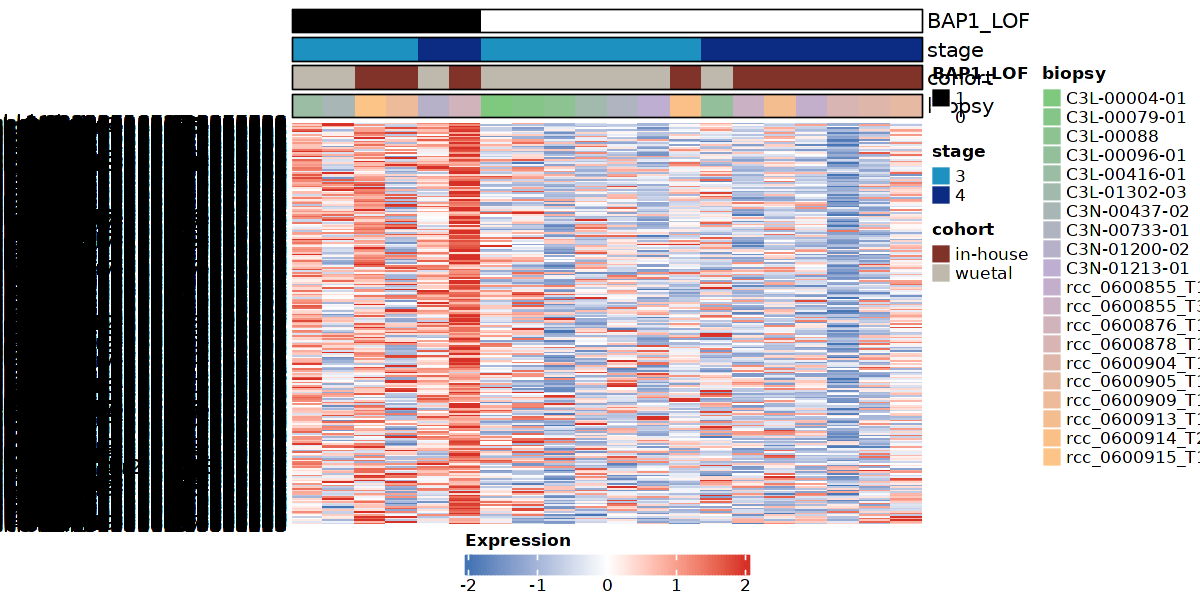

In [13]:
# Colors
tumor_cols <- c('black','white')
cohort_cols = c('#823329','#BFB8AD')
sample_cols <- colorRampPalette(brewer.pal(10, "Accent"))(65)
stage = c('#1d91c0','#0c2c84')

# Order
sigpeak_obj$BAP1_LOF = factor(sigpeak_obj$BAP1_LOF, levels = c(1,0))
sigpeak_obj$stage = factor(sigpeak_obj$stage)

# Plot
options(repr.plot.width=10, repr.plot.height=5)
plot_heatmap(sigpeak_obj, markers = filtered_markers$gene,anno_var = c('BAP1_LOF','stage','cohort','biopsy'),
             anno_colors = list(tumor_cols, stage, cohort_cols, sample_cols), sort_var = c('BAP1_LOF','stage'))


## Decreased accessibility with pLOF BAP1 mutation

Filter DAP results to those with decreased accessibility

In [14]:
filtered_markers = markers %>% filter((p_val_adj < 0.05) & (avg_log2FC < -1))

Create an average accessibility object

In [15]:
DefaultAssay(tumor_bap1) = 'ATAC'
sigpeak_obj = subset(tumor_bap1, features = filtered_markers$gene)
Idents(sigpeak_obj) = 'biopsy'
DefaultAssay(sigpeak_obj) = 'ATAC'
sigpeak_obj = AverageExpression(sigpeak_obj, return.seurat = T)

Centering and scaling data matrix



Add in desired metadata for the heatmap

In [16]:
sigpeak_obj$biopsy = row.names(sigpeak_obj@meta.data)
add_meta = tumor_bap1@meta.data %>% dplyr::select(c('biopsy','cohort','BAP1_LOF','stage')) %>% distinct()
row.names(add_meta) = add_meta$biopsy

sigpeak_obj = AddMetaData(sigpeak_obj, metadata = add_meta)

**Plot**

Warning message in brewer.pal(10, "Accent"):
"n too large, allowed maximum for palette Accent is 8
Returning the palette you asked for with that many colors
"


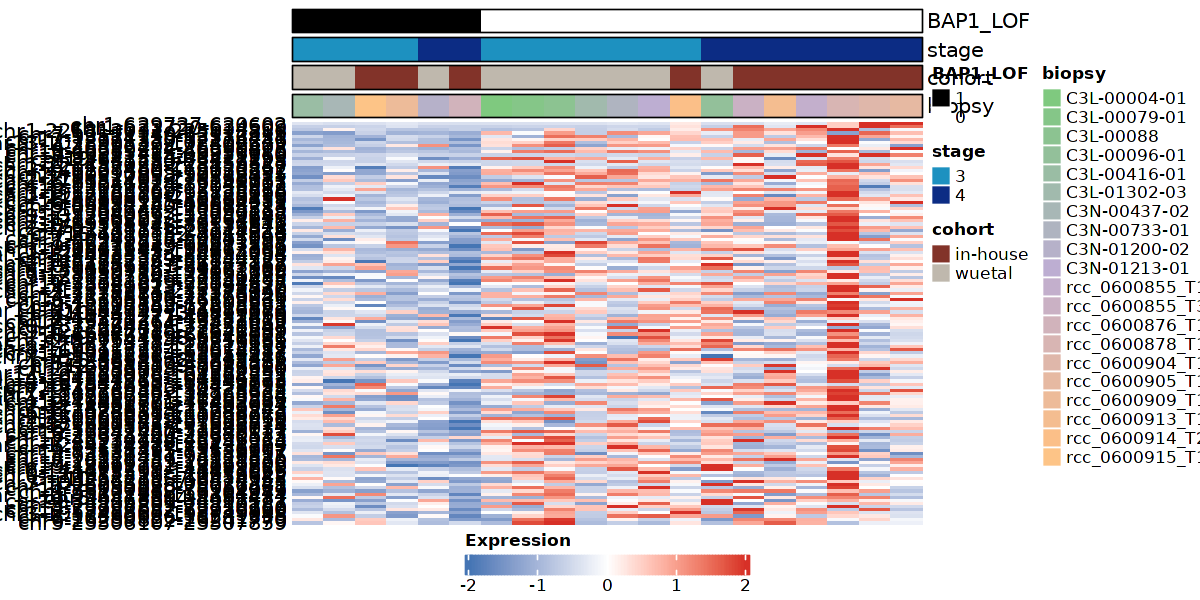

In [17]:
# Colors
tumor_cols <- c('black','white')
cohort_cols = c('#823329','#BFB8AD')
sample_cols <- colorRampPalette(brewer.pal(10, "Accent"))(65)
stage = c('#1d91c0','#0c2c84')

# Order
sigpeak_obj$BAP1_LOF = factor(sigpeak_obj$BAP1_LOF, levels = c(1,0))
sigpeak_obj$stage = factor(sigpeak_obj$stage)

# Plot
options(repr.plot.width=10, repr.plot.height=5)
plot_heatmap(sigpeak_obj, markers = filtered_markers$gene,anno_var = c('BAP1_LOF','stage','cohort','biopsy'),
             anno_colors = list(tumor_cols, stage, cohort_cols, sample_cols), sort_var = c('BAP1_LOF','stage'))


# Figure 3C: TF motif binding sites enriched in BAP1 pLOF peak set

Motif enrichment results in Supp table 3, sheet B. 

In [18]:
filtered_up = markers %>% filter((p_val_adj < 0.05) & (avg_log2FC >1))

In [19]:
DefaultAssay(tumor_bap1) = 'ATAC'

# For peaks enriched in BAP1 mt
## Define a set of background peaks
## Find peaks that are open in a significant portion of cells
percent_to_num_cells = ceiling(nrow(tumor_bap1@meta.data) * 0.1)
open_peaks <- AccessiblePeaks(tumor_bap1, min.cells = percent_to_num_cells)

## Match the overall GC content in the peak set
meta.feature <- GetAssayData(tumor_bap1, assay = "ATAC", slot = "meta.features")
peaks_matched <- MatchRegionStats(
meta.feature = meta.feature[open_peaks, ],
query.feature = meta.feature[filtered_up$gene, ]
)

# Determine enrichment of motifs in peak set - Hypergeometric test
df1 <- FindMotifs(
    object = tumor_bap1,
    features = filtered_up$gene,
    background = peaks_matched
    )

Matching GC.percent distribution

Testing motif enrichment in 4014 regions



In [20]:
max(df1$fold.enrichment)

[1] 1.62988

Warning message:
"ggrepel: 9 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


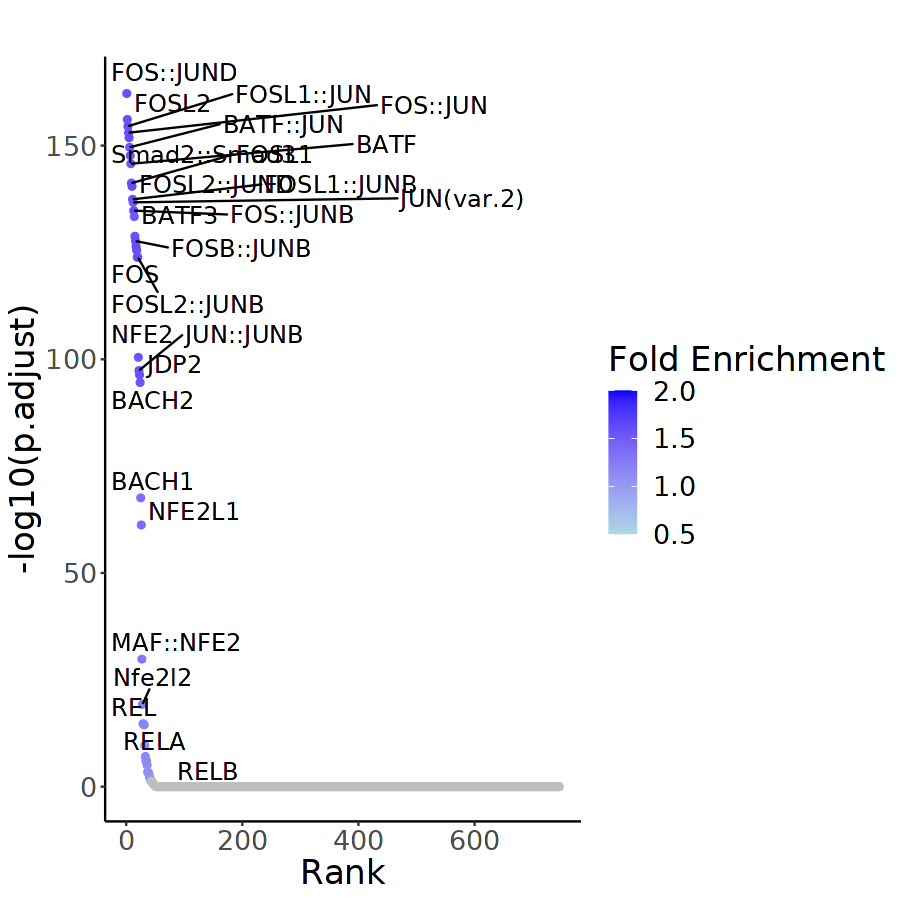

In [21]:
options(repr.plot.width=7.5, repr.plot.height=7.5)
create_motif_significance_plot(df1, n_annotate = 30, specific_substr = c('RELA|REL'), color_gradient_limits = c(0.5,2), max_overlaps = 10) + ggtitle("")


# Figure 3D: GREAT pathway results for BAP1 pLOF peak set

GREAT pathway results in Supp table 3, sheet C. 

In [23]:
# Read in GREAT results
header = read.table('allcells/tumor/great/greatExportAll_forheader.tsv', fill = TRUE, sep = "\t", quote = "", row.names = NULL)
header = unlist(unname(t(header[1,])[,1]))

great_results = read.table('allcells/tumor/great/BAP1/BAP1_LOF_up_hg19_latestage_pathways.tsv',  sep = "\t", quote = "", row.names = NULL, fill = TRUE)
colnames(great_results) = header
great_results = great_results[,-c(23,24)]

# Subset results using filters implemented on GREAT website
great_results$Ontology2 = great_results$Ontology
great_results = great_results %>%
filter((Ontology == 'GO Biological Process') &
       (RegionFoldEnrich > 2) &
        (TotalGenes > 1) &
        (BinomFdrQ < 0.05) &
        (HyperFdrQ < 0.05)) 

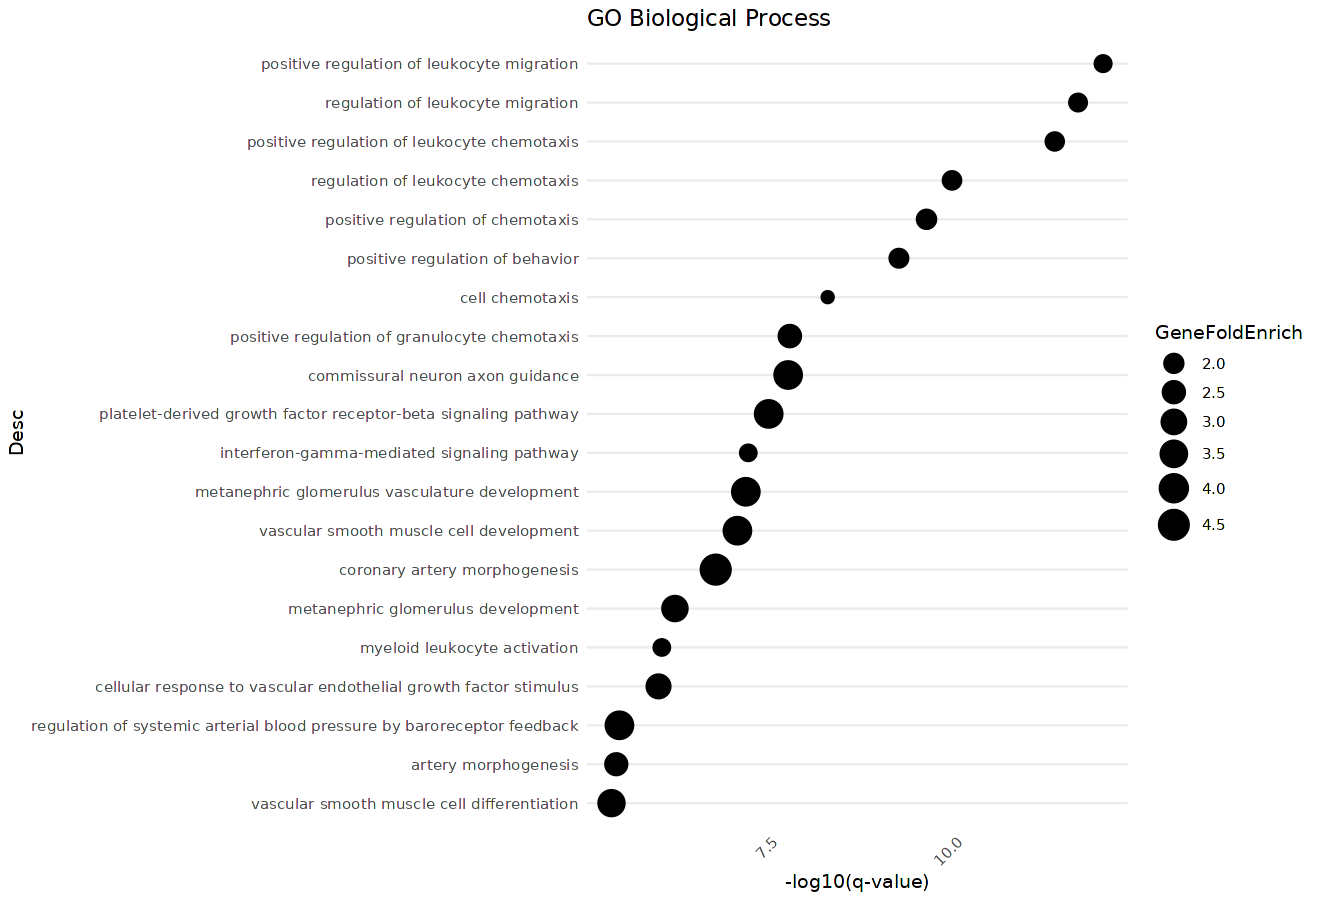

In [27]:
# Get top 20 pathways and format q-values
top_desc <- great_results %>%
  arrange(BinomP) %>%
  slice_head(n = 20) %>%
  mutate(
    neg_log10_BinomFdrQ = -log10(BinomFdrQ),
    Desc = fct_reorder(Desc, neg_log10_BinomFdrQ)
  )

# Plot
options(repr.plot.width = 11, repr.plot.height = 7.5)

ggplot(data = top_desc, aes(x = Desc, y = neg_log10_BinomFdrQ, size = GeneFoldEnrich)) +
    geom_point(color = "black") +
    theme_minimal() +
    labs(title = "GO Biological Process",
       y = "-log10(q-value)") +
    coord_flip() +
    scale_size_continuous(range = c(3, 8)) + # Adjust size range as needed
    theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank()
    )

# Figure 3E: Immune cell type proportions between BAP1 pLOF and WT biopsies

In [4]:
allcells = readRDS('allcells/seurat_obj/integrated_allcohorts_seuratobj_geneactivity_lsi_metadata_qc_motifs_annotated_detailed.rds')

Get pLOF mutation info per sample

In [5]:
sample_biopsy_mapping = allcells@meta.data %>% dplyr::select(sample,biopsy) %>% distinct()
mutations = read.table('../../snatac-rcc-manuscript-data/comut_muts.txt', sep = '\t')
mutations_filtered = mutations %>% filter(!(value %in% c('Missense','In frame indel', 'Unable to determine')))
combined_muts_bysample = dplyr::left_join(mutations_filtered, sample_biopsy_mapping, by = 'biopsy')

Warning message in dplyr::left_join(mutations_filtered, sample_biopsy_mapping, by = "biopsy"):
"Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 26 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence this warning."


Create mutation matrix to add to Seurat object's metadata

In [6]:
# Create starter matrix based off of samples w/ mutations
mutation_matrix = combined_muts_bysample %>% dplyr::select(c('sample','category')) %>%
  tidyr::pivot_wider(names_from = category, values_from = category, values_fn = length, values_fill = 0)
sampleids = unique(allcells$sample)

# Samples with no mutation info should be NAs
no_mut_data = c('rcc_0600855_T2', 'rcc_0600920_T1','rcc_RCCT1324-T1A')
missing_rows <- data.frame(sample = no_mut_data)
missing_rows[, unique(colnames(mutation_matrix)[-1])] <- NA

# If a sample did get sequencing but no mutations are found the entry should be 0
new_rows <- data.frame(sample = setdiff(sampleids, c(mutation_matrix$sample, no_mut_data)))
new_rows[, unique(colnames(mutation_matrix)[-1])] <- 0

# Concatenate together
mutation_matrix <- rbind(mutation_matrix, missing_rows, new_rows)

# Set column names that will be in metadata
colnames(mutation_matrix) = c('sample','SETD2_LOF', 'KDM5C_LOF','VHL_LOF','BAP1_LOF','PBRM1_LOF')

# Index by cell barcode and add to Seurat object
shared_states_lof = dplyr::left_join(allcells@meta.data %>% dplyr::select('new_barcodes', 'sample'), mutation_matrix, by = 'sample')
row.names(shared_states_lof) = shared_states_lof$new_barcodes
shared_states_lof$new_barcodes = NULL
allcells = AddMetaData(allcells, shared_states_lof)

Filter to cells to QC-passing from patients with late stage clear cell ccRCC

In [7]:
metadata = allcells@meta.data %>% filter((BAP1_LOF == 1) | (BAP1 == 0))
metadata = metadata %>% filter((broad_celltype_excluded != 'Excluded') & (stage %in% c('3','4')) & (histology == 'Clear cell'))
metadata$BAP1_status = ifelse(metadata$BAP1_LOF == 1, 'pLOF', 'WT')

Calculate immune cell type proportion

In [8]:
# Grouping by cell type, biopsy, and BAP1 status
grouped_df <- metadata %>%
  group_by(broad_celltype_excluded, biopsy, BAP1_status) %>%
  summarise(cell_count = n(), .groups = 'drop')

# Calculating total cells per biopsy
total_cells_per_biopsy <- grouped_df %>%
  group_by(biopsy) %>%
  summarise(total_cells = sum(cell_count), .groups = 'drop')

# Merging to get total cells in each biopsy alongside each group
merged_df <- merge(grouped_df, total_cells_per_biopsy, by = "biopsy")

# Calculating the proportion
merged_df <- merged_df %>%
  mutate(proportion = cell_count / total_cells)

# Selecting relevant columns
all_everything_props = merged_df %>%
  dplyr::select(biopsy, broad_celltype_excluded, BAP1_status, proportion, total_cells)

# Add in stage information
all_everything_props = dplyr::left_join(all_everything_props, metadata %>% dplyr::select(c('biopsy','stage')), by = 'biopsy') %>% distinct()
all_everything_props$stage = factor(all_everything_props$stage)

Warning message in dplyr::left_join(all_everything_props, metadata %>% dplyr::select(c("biopsy", :
"Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 1 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence this warning."


Set immune cell type order and only plot immune cell types

In [9]:
all_everything_props$BAP1_status = factor(all_everything_props$BAP1_status, levels = c('WT','pLOF'))
immune_infiltrate_plot = all_everything_props %>% filter(!(broad_celltype_excluded %in% c('Tumor',"Endothelial", "Perivascular cell", "Fibroblast")))
immune_infiltrate_plot$broad_celltype_excluded = factor(immune_infiltrate_plot$broad_celltype_excluded,
                                                        levels = rev(c('CD8 T cell', 'T-helper','T-reg','NK','Plasma cell','B cell','TAM','Monocyte','MoDC', 'cDC')))


Calculate p-value and q-values for comparisons

In [10]:
celltypes = unique(immune_infiltrate_plot$broad_celltype_excluded)
results = list()
for (i in 1:length(celltypes)) {
    celltype = celltypes[i]
    celltype_meta = immune_infiltrate_plot
    celltype_meta$broad_celltype_excluded = as.character(celltype_meta$broad_celltype_excluded)
    celltype_meta = celltype_meta %>% filter(broad_celltype_excluded == celltype)
    bap1_mt_prop_vector = (celltype_meta %>% filter(BAP1_status == 'pLOF'))$proportion
    bap1_wt_prop_vector =(celltype_meta %>% filter(BAP1_status == 'WT'))$proportion
    test = wilcox.test(x = bap1_mt_prop_vector, y = bap1_wt_prop_vector)
    side = ifelse(median(bap1_mt_prop_vector) > median(bap1_wt_prop_vector), 'pLOF', 'WT')
    results[[i]] = data.frame(celltype = celltype, pvalue = test$p.value, side = side)
}

results_df = dplyr::bind_rows(results)
results_df$padjust = p.adjust(p = results_df$pvalue, method = 'fdr')
results_df

celltype,pvalue,side,padjust
<fct>,<dbl>,<chr>,<dbl>
CD8 T cell,0.129669763,pLOF,0.43223254
MoDC,0.391296870,pLOF,0.80866193
Monocyte,0.002063983,pLOF,0.02063983
NK,0.718059856,WT,0.83141678
cDC,0.831416777,pLOF,0.83141678
T-reg,0.404330963,pLOF,0.80866193
B cell,0.826923077,pLOF,0.83141678
Plasma cell,0.825174825,pLOF,0.83141678
T-helper,0.601547988,pLOF,0.83141678


Plot

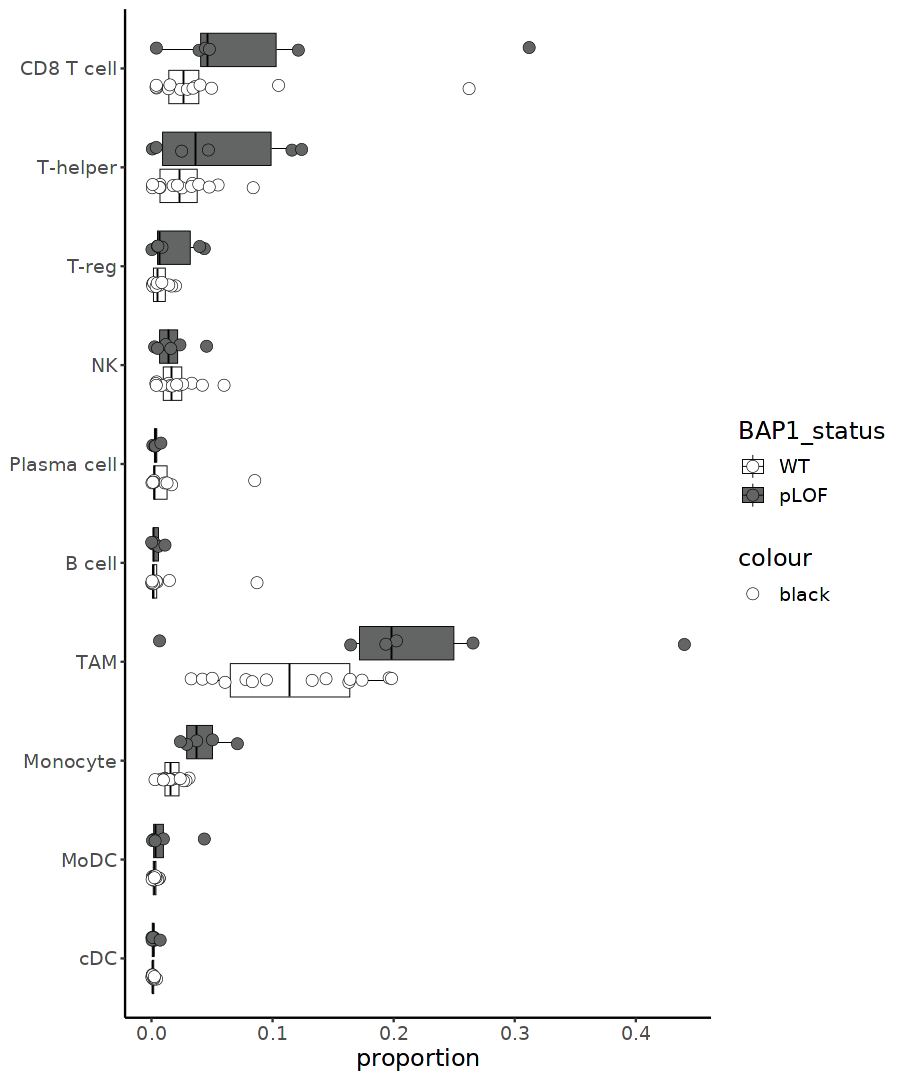

In [11]:
options(repr.plot.width=7.5, repr.plot.height=9)
immune_infiltrate_plot %>% ggplot(., aes(x = broad_celltype_excluded, y = proportion, fill = BAP1_status)) +
geom_boxplot(outlier.shape = NA, color = 'black', lwd = 0.2) +
  geom_point(position = position_jitterdodge(jitter.width = 0.1), alpha = 1, aes(color = 'black'), pch = 21 ,stroke =0.2, size = 3) + coord_flip() + theme_classic() + theme(text = element_text(size = 14)) +
theme(axis.title.y  = element_blank()) + scale_fill_manual(values = c('white','#636464'))+ scale_color_manual(values = c('black', 'white')) 
